In [0]:
!pip install torch
!pip install torchvision

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch as torch


In [0]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from scipy import io
import pandas as pd


In [0]:
act_list = ["bend/bow (at the waist)", "crawl", "crouch/kneel", "dance", "fall down", "get up", "jump/leap", "lie/sleep", "martial art", "run/jog", "sit", "stand", "swim", "walk", "answer phone", "brush teeth", "carry/hold (an object)", "catch (an object)", "chop", "climb (e.g., a mountain)", "clink glass", "close (e.g., a door, a box)", "cook", "cut", "dig", "dress/put on clothing", "drink", "drive (e.g., a car, a truck)", "eat", "enter", "exit", "extract", "fishing", "hit (an object)", "kick (an object)", "lift/pick up", "listen (e.g., to music)", "open (e.g., a window, a car door)", "paint", "play board game", "play musical instrument", "play with pets", "point to (an object)", "press", "pull (an object)", "push (an object)", "put down", "read", "ride (e.g., a bike, a car, a horse)", "row boat", "sail boat", "shoot", "shovel", "smoke", "stir", "take a photo", "text on/look at a cellphone", "throw", "touch (an object)", "turn (e.g., a screwdriver)", "watch (e.g., TV)", "work on a computer", "write", "fight/hit (a person)", "give/serve (an object) to (a person)", "grab (a person)", "hand clap", "hand shake", "hand wave", "hug (a person)", "kick (a person)", "kiss (a person)", "lift (a person)", "listen to (a person)", "play with kids", "push (another person)", "sing to (e.g., self, a person, a group)", "take (an object) from (a person)", "talk to (e.g., self, a person, a group)", "watch (a person)"]

In [0]:
act_dict = {}
for i in range(len(act_list)) :
    act_dict[i+1] = act_list[i]


In [5]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_asd = pd.read_csv(r"drive/My Drive/ava/ava-human-searches_anno.csv")

In [0]:
actions_considered = df_asd['target-action'].unique()

In [8]:
actions_considered

array(['clink glass', 'drink', 'dance', 'hug (a person)',
       'sing to (e.g., self, a person, a group)', 'hand clap',
       'take a photo', 'play musical instrument', 'smoke',
       'kiss (a person)', 'hand shake', 'swim', 'jump/leap', 'eat',
       'drive (e.g., a car, a truck)', 'write', 'shoot', 'martial art',
       'push (another person)', 'work on a computer'], dtype=object)

# Random Baseline

In [0]:
df_ava_test = pd.read_csv(r"drive/My Drive/ava/ava_test_v1.0_v.csv", names  = ['video_id', 'middle_frame_timestamp', 'x1', 'y1', 'x2', 'y2', 'action_id'])

In [10]:
df_ava_test.head(5)

,video_id,middle_frame_timestamp,x1,y1,x2,y2,action_id
0,053oq2xB3oU,904,0.061,0.168,0.774,0.877,11
1,053oq2xB3oU,904,0.302,0.242,0.560,0.657,12
2,053oq2xB3oU,904,0.661,0.241,0.894,0.857,11
3,053oq2xB3oU,904,0.837,0.221,0.991,0.858,12
4,053oq2xB3oU,907,0.000,0.201,0.313,0.964,12


In [0]:
MIN = df_ava_test.middle_frame_timestamp.min()

In [12]:
MIN

904

In [0]:
MAX = df_ava_test.middle_frame_timestamp.max()

In [14]:
MAX

1798

In [0]:
import random

def find_action_r(dataf) :    
    
    search_num = 1;
    
    for i in range(500) :
        guess_time = random.randint(MIN, MAX)
        if guess_time in dataf:
            break;
        if (guess_time - 1 in dataf) & (guess_time + 2 in dataf):
            break;
        if (guess_time - 2 in dataf) & (guess_time + 1 in dataf):
            break;
        else :
            search_num = search_num + 1
    
    return search_num

In [0]:
actions = df_ava_test['action_id'].unique()

In [58]:
len(actions)

1

In [0]:
actions = [4]

In [72]:
for action in actions :
    if not (act_dict[action] in actions_considered) :
      continue
    print('Action', act_dict[action])

    df_ava_test_action = df_ava_test[(df_ava_test['action_id'] == action)]
    epochs = 5
    
    total = 0;
    count = 0;
    
    for epoch in range(epochs) :
        
        videos_with_action = df_ava_test_action['video_id'].unique()
        # For particular video
        for video in videos_with_action[:1] :
            df_ava_video_action = df_ava_test_action[(df_ava_test_action['video_id'] == video) & (df_ava_test_action['action_id'] == action)]
    
            print('Video', video)

            as_metric = 500
            while (as_metric == 500) :
                as_metric = find_action_r(df_ava_video_action['middle_frame_timestamp'].tolist())

            print('Action : %s , Spotted in : %i' % (act_dict[action], as_metric))
            total = total + as_metric
            count = count + 1
    print('avg', total/count)

Action dance
Video 4ZpjKfu6Cl8
Action : dance , Spotted in : 22
Video 4ZpjKfu6Cl8
Action : dance , Spotted in : 81
Video 4ZpjKfu6Cl8
Action : dance , Spotted in : 61
Video 4ZpjKfu6Cl8
Action : dance , Spotted in : 12
Video 4ZpjKfu6Cl8
Action : dance , Spotted in : 43
avg 43.8


# With Direction

In [0]:
actions = [4]
df_ava_test = pd.read_csv(r"drive/My Drive/ava/ava_test_v1.0_v.csv", names  = ['video_id', 'middle_frame_timestamp', 'x1', 'y1', 'x2', 'y2', 'action_id'])

In [101]:
df_ava_working_test_id = pd.read_csv('drive/My Drive/ava/test_videos/working_ids.txt', names  = ['video_id'])
working_video_list = df_ava_working_test_id['video_id'].unique()
working_video_list

array(['4ZpjKfu6Cl8', '7YpF6DntOYw', 'BCiuXAuCKAU', 'HKjR70GCRPE',
       'IzvOYVMltkI', 'LgBQlW6OTr0', 'P60OxWahxBQ', 'g1wyIcLPbq0',
       'kMy-6RtoOVU', 'yn9WN9lsHRE', 'z-fsLpGHq6o', 'zC5Fh2tTS1U',
       'zR725veL-DI'], dtype=object)

In [102]:
df_ava_test = df_ava_test[(df_ava_test['action_id'].isin(actions) )]
videos_reqs = pd.DataFrame(df_ava_test['video_id'].unique())
# videos_reqs.to_csv('drive/My Drive/ava/test_videos_list_for_direction.csv')
videos_reqs

,0
0,4ZpjKfu6Cl8
1,8VZEwOCQ8bc
2,9IF8uTRrWAM
3,BCiuXAuCKAU
4,XIx-C22Ewk4
5,z-fsLpGHq6o
6,zC5Fh2tTS1U


In [0]:
VIDEO_PATH = "drive/My Drive/ava/test_video_resized/"

In [0]:
import random

def find_action_d(dataf, video, model) : 
  
    guess_time = random.randint(MIN, MAX)
    
    search_num = 1;
 
    for i in range(500) :
        
      if guess_time in dataf:
          break;
      if (guess_time - 1 in dataf) & (guess_time + 2 in dataf):
          break;
      if (guess_time - 2 in dataf) & (guess_time + 1 in dataf):
          break;
      else :
          search_num = search_num + 1
          
      cap = cv2.VideoCapture(VIDEO_PATH + str(video) + ".mp4")
#       print(VIDEO_PATH + str(video) + ".mp4")
      cap.set(cv2.CAP_PROP_POS_MSEC,(guess_time - MIN) * 1000)
      ret, frame = cap.read()
      
      frame = np.rollaxis(frame, 2,0)
      frame = torch.from_numpy(frame)
      frame = frame.unsqueeze(0)
#       print(frame.shape)

      x_var = Variable(frame.float().cuda())

      op = model(x_var)
      op = op.detach().cpu().numpy()
      index = op.argmax(axis=1)
      if (index == 0) :
        guess_time = random.randint(MIN, guess_time)
      elif (index == 1) :
        if not (guess_time == MAX) :
          guess_time = random.randint(guess_time + 1, MAX)
        else : 
          guess_time = random.randint(MIN, MAX)
    return search_num

In [115]:
for action in actions :
    if not (act_dict[action] in actions_considered) :
      continue
    print('Action', act_dict[action])
    model = torch.load('drive/My Drive/models/50act4_m.h5')
#     print(model)

    df_ava_test_action = df_ava_test[(df_ava_test['action_id'] == action)]
    epochs = 5
    
    total = 0;
    count = 0;
    
    for epoch in range(epochs) :
        
        videos_with_action = df_ava_test_action['video_id'].unique()
        # For particular video
        for video in videos_with_action[:1] :
            if not video in working_video_list :
              continue
            print(video)
            df_ava_video_action = df_ava_test_action[(df_ava_test_action['video_id'] == video) & (df_ava_test_action['action_id'] == action)]
    
#             print('Video', video)

            as_metric = 100
            while (as_metric == 100) :
                as_metric = find_action_d(df_ava_video_action['middle_frame_timestamp'].tolist(), video, model)

            print('Action : %s , Spotted in : %i' % (action, as_metric))
            total = total + as_metric
            count = count + 1
#     print('avg', total/count)

Action dance
4ZpjKfu6Cl8


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Action : 4 , Spotted in : 16
4ZpjKfu6Cl8
Action : 4 , Spotted in : 15
4ZpjKfu6Cl8


KeyboardInterrupt: ignored

# With LSTM

In [0]:
actions = [4]
df_ava_test = pd.read_csv(r"drive/My Drive/ava/ava_test_v1.0_v.csv", names  = ['video_id', 'middle_frame_timestamp', 'x1', 'y1', 'x2', 'y2', 'action_id'])

In [83]:
df_ava_working_test_id = pd.read_csv('drive/My Drive/ava/test_videos/working_ids.txt', names  = ['video_id'])
working_video_list = df_ava_working_test_id['video_id'].unique()
working_video_list

array(['4ZpjKfu6Cl8', '7YpF6DntOYw', 'BCiuXAuCKAU', 'HKjR70GCRPE',
       'IzvOYVMltkI', 'LgBQlW6OTr0', 'P60OxWahxBQ', 'g1wyIcLPbq0',
       'kMy-6RtoOVU', 'yn9WN9lsHRE', 'z-fsLpGHq6o', 'zC5Fh2tTS1U',
       'zR725veL-DI'], dtype=object)

In [84]:
df_ava_test = df_ava_test[(df_ava_test['action_id'].isin(actions) )]
videos_reqs = pd.DataFrame(df_ava_test['video_id'].unique())
# videos_reqs.to_csv('drive/My Drive/ava/test_videos_list_for_direction.csv')
videos_reqs

,0
0,4ZpjKfu6Cl8
1,8VZEwOCQ8bc
2,9IF8uTRrWAM
3,BCiuXAuCKAU
4,XIx-C22Ewk4
5,z-fsLpGHq6o
6,zC5Fh2tTS1U


In [0]:
VIDEO_PATH = "drive/My Drive/ava/test_videos/"

In [86]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
# resnet50.avgpool = torch.nn.AdaptiveAvgPool2d(1)
visual_encoder = nn.Sequential(*list(resnet50.children())[:-1])
visual_encoder.cuda()
visual_encoder.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [0]:
import random

def find_action2(dataf, video, model) : 
  
    guess_time = random.randint(MIN, MAX)
    
    search_num = 1;
 
    for i in range(500) :
      print('guess_time ' + str(guess_time))
        
      if guess_time in dataf:
          break;
      if (guess_time - 1 in dataf) & (guess_time + 2 in dataf):
          break;
      if (guess_time - 2 in dataf) & (guess_time + 1 in dataf):
          break;
      else :
          search_num = search_num + 1
          
      cap = cv2.VideoCapture(VIDEO_PATH + str(video) + ".mp4")
      print(VIDEO_PATH + str(video) + ".mp4")
      cap.set(cv2.CAP_PROP_POS_MSEC,(guess_time - MIN) * 1000)
      ret, frame = cap.read()
      frame = np.rollaxis(frame, 2,0)
      frame = torch.from_numpy(frame)
      frame = frame.unsqueeze(0)
      print(frame.shape)

      x_var = Variable(frame.float().cuda())

      op = model(x_var)
      op = op.detach().cpu().numpy()
      print(op)
#       index = op.argmax(axis=1)
#       print(index)
#       if (index == 0) :
#         guess_time = random.randint(MIN, guess_time)
#       elif (index == 1) :
#         guess_time = random.randint(guess_time + 1, MAX)
    
    return search_num

In [0]:
def get_preds(frame, visual_encoder, lstm_model) :
  
    hidden = (torch.randn(1, 1, 1000).cuda(),
          torch.randn(1, 1, 1000).cuda())
    img = np.rollaxis(frame, 2, 0)   
#       cv2.imshow("frame", cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
#       cv2.waitKey()

    t = torch.from_numpy(img)
    x_var = Variable(t.unsqueeze(0).float().cuda())
#       print(x_var.shape)

    output = visual_encoder(x_var).data.cpu().numpy() 
#       print(output.shape)
    op = output.reshape(-1, 16)
#       print(op.shape)

    mean, eigvec = cv2.PCACompute(op, mean=None, maxComponents = 64)
#       print(eigvec.shape)

    op = eigvec.reshape(1, 1, -1)
    t2 = torch.from_numpy(op)
    x_var2 = Variable(t2.float().cuda())

#       print(x_i)
    out_lstm, hidden = lstm_model[0](x_var2, hidden)
    preds = lstm_model[1](out_lstm)
    return preds

In [0]:
import random

def find_action_l(dataf, video, model, visual_encoder) :
  
    guess_time = random.randint(MIN, MAX)
    
    search_num = 1;
 
    for i in range(200) :
 
      print('guess_time ' + str(guess_time))
        
      if guess_time in dataf:
          break;
      if (guess_time - 1 in dataf) & (guess_time + 2 in dataf):
          break;
      if (guess_time - 2 in dataf) & (guess_time + 1 in dataf):
          break;
      else :
          search_num = search_num + 1
          
      cap = cv2.VideoCapture(VIDEO_PATH + str(video) + ".mp4")
#       print(VIDEO_PATH + str(video) + ".mp4")
      
      cap.set(cv2.CAP_PROP_POS_MSEC,(guess_time) * 1000)
      ret, frame = cap.read()
      
      %matplotlib inline
      from matplotlib import pyplot as plt
      plt.imshow(frame)
      plt.show()
      
      
      guess_time += int(get_preds(frame, visual_encoder, model).squeeze().detach().cpu().numpy()*10)
#       index = op.argmax(axis=1)
#       print(index)
#       if (index == 0) :
#         guess_time = random.randint(MIN, guess_time)
#       elif (index == 1) :
#         guess_time = random.randint(guess_time + 1, MAX)
    
    return search_num

Action dance
4ZpjKfu6Cl8
guess_time 1048


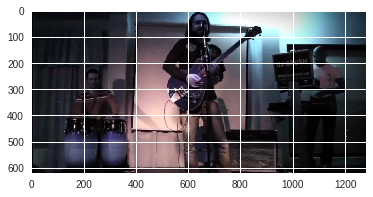

guess_time 1037


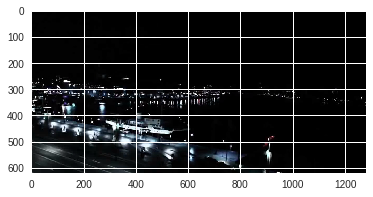

guess_time 1028


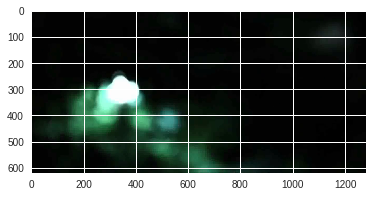

guess_time 1016


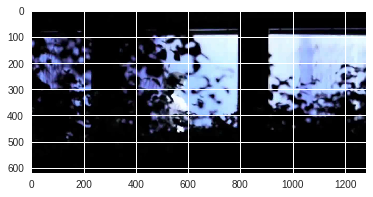

guess_time 1028


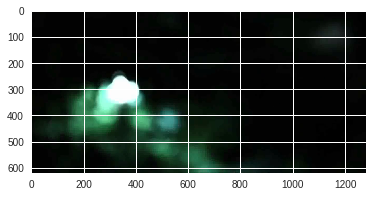

guess_time 1026


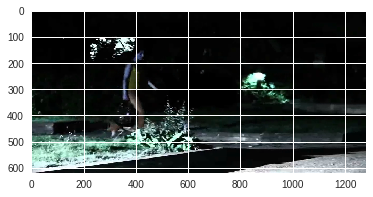

guess_time 1065


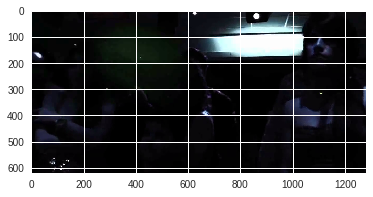

guess_time 1085


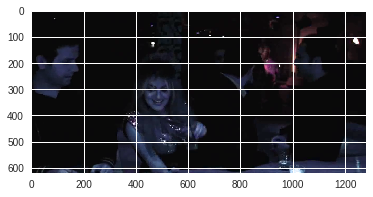

guess_time 1081


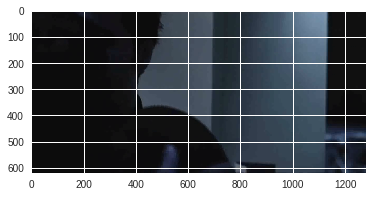

guess_time 1088


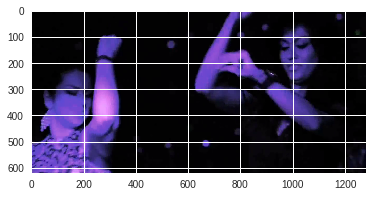

guess_time 1071


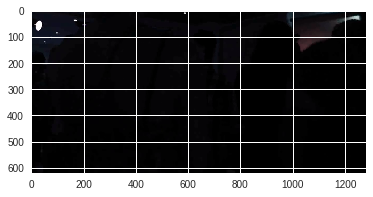

guess_time 1067


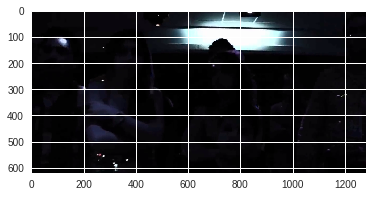

guess_time 1079


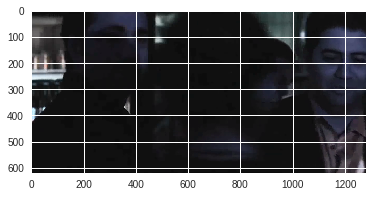

guess_time 1065


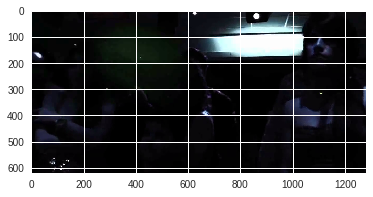

guess_time 1063
Action : 4 , Spotted in : 15
4ZpjKfu6Cl8
guess_time 1767


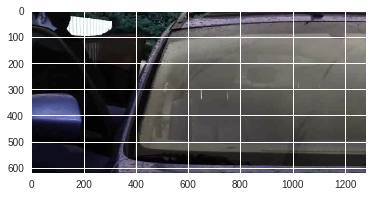

guess_time 1771


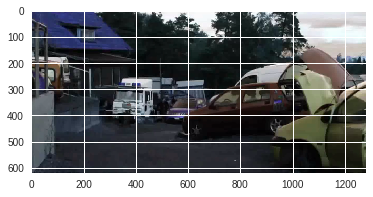

guess_time 1775


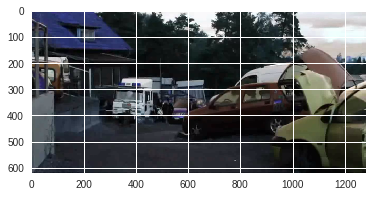

guess_time 1792


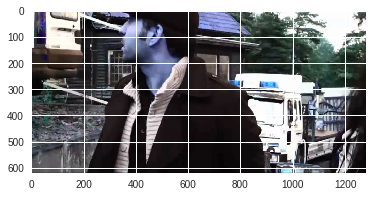

guess_time 1786


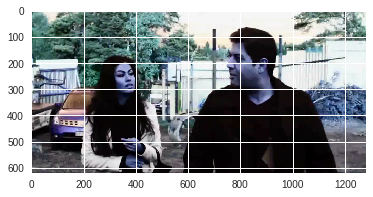

guess_time 1772


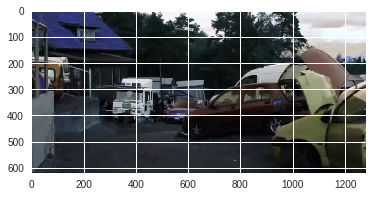

guess_time 1767


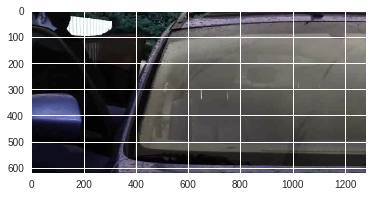

guess_time 1764


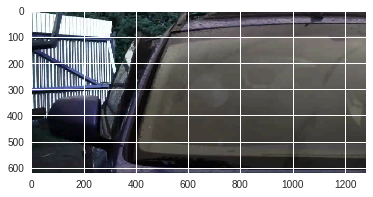

guess_time 1763


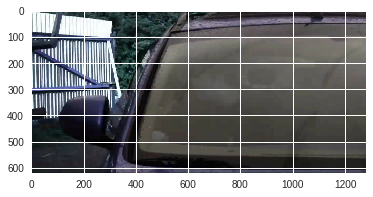

guess_time 1748


KeyboardInterrupt: ignored

In [54]:
for action in actions :
    if not (act_dict[action] in actions_considered) :
      continue
    print('Action', act_dict[action])
    model = torch.load('drive/My Drive/lstm_model_f.h5')
#     print(model)

    df_ava_test_action = df_ava_test[(df_ava_test['action_id'] == action)]
    epochs = 10
    
    total = 0;
    count = 0;
    
    for epoch in range(epochs) :
        
        videos_with_action = df_ava_test_action['video_id'].unique()
        # For particular video
        for video in videos_with_action[:1] :
            if not video in working_video_list :
              continue
            print(video)
            df_ava_video_action = df_ava_test_action[(df_ava_test_action['video_id'] == video) & (df_ava_test_action['action_id'] == action)]
    
#             print('Video', video)

            as_metric = 100
            while (as_metric == 100) :
                as_metric = find_action_l(df_ava_video_action['middle_frame_timestamp'].tolist(), video, model, visual_encoder)

            print('Action : %s , Spotted in : %i' % (action, as_metric))
            total = total + as_metric
            count = count + 1
#     print('avg', total/count)